In [2]:
%load_ext autoreload

In [14]:
from scipy.ndimage import affine_transform
import scipy
import tifffile as tiff
import os
import numpy as np
import copy
from pathlib import Path
import sys
import matplotlib.pyplot as plt

PIPELINE_ROOT =  Path().resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())

In [89]:
from library.image_manipulation.pipeline_process import Pipeline
from library.image_manipulation.elastix_manager import create_downsampled_transforms
from library.utilities.utilities_registration import (
    parameters_to_rigid_transform,
    rigid_transform_to_parmeters,
)
from library.image_manipulation.image_manager import ImageManager
#from settings import host, password, user, schema
channel = 1
downsample = True
debug = False
rescan_number = 0
task = 'align'

In [17]:
class ManualAligner(Pipeline):
    
    def __init__(self, animal, section):
        """"
        below midfile
        increase xshift of section pushes preceding images to the right
        decrease xshift of section pushes preceding images to the left
        increase yshift of moving pushes preceding images down
        decrease yshift of moving pushes preceding images up
        increase rotation of moving rotates preceding images clockwise
        decrease rotation of moving rotates preceding images counterclockwise
        """
        super().__init__(animal, rescan_number, channel, downsample, 
                         task, debug)
        self.sections = self.sqlController.get_sections(self.animal, self.channel, rescan_number)
        self.midpoint = len(self.sections) // 2
        self.moving_index = section - 1
        self.fixed_index = section
        INPUT = os.path.join(self.fileLocationManager.prep, 'C1', 'thumbnail_aligned')
        self.moving_file = os.path.join(INPUT, f'{str(self.moving_index).zfill(3)}.tif')
        self.fixed_file = os.path.join(INPUT, f'{str(self.fixed_index).zfill(3)}.tif')
        self.moving = tiff.imread(self.moving_file)
        self.fixed = tiff.imread(self.fixed_file)
        self.transformations = self.get_transformations()
        self.center = self.get_rotation_center()
        
    def transform_image(self, img, T):
        matrix = T[:2,:2]
        offset = T[:2,2]
        offset = np.flip(offset)
        img = affine_transform(img, matrix.T, offset)
        return img
    
    def evalulate_transformation(self, fixed, moving, Tf, Tm):
        fixed = self.transform_image(fixed, Tf)
        moving = self.transform_image(moving, Tm)
        self.compare_two_image(fixed, moving)
        
    def image_side_by_side(self, fixed, moving, Tf=None, Tm=None):
        if Tm is not None:
            fixed = self.transform_image(fixed, Tf)
            moving = self.transform_image(moving, Tm)
        fig, ax = plt.subplots(1,2)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        ax[0].grid()
        ax[1].grid()
        ax[0].title.set_text(f'fixed {self.fixed_index}')
        ax[1].title.set_text(f'moving {self.moving_index}')
        ax[0].imshow(fixed, cmap="gray")
        ax[1].imshow(moving, cmap="gray")
        
    def compare_two_image(self, img1, img2):
        img1,img2 = img1.astype(float),img2.astype(float)
        plt.figure(figsize=[20,20])
        plt.imshow(img1,cmap='Blues')
        plt.imshow(img2,alpha=0.5,cmap='Greys')
         
    def get_transformations(self):
        transformations = {}
        center = self.get_rotation_center()
        for i in range(1, len(self.sections)):
            rotation, xshift, yshift = self.load_elastix_transformation(self.animal, i)
            T = parameters_to_rigid_transform(rotation, xshift, yshift, center)
            transformations[i] = T
        return transformations

    def get_transformation_of_section_to_midpoint(self, section, transformations):
        if section == self.midpoint:
            transformation = np.eye(3)
        elif section < self.midpoint:
            T_composed = np.eye(3)
            for i in range(self.midpoint, section, -1):
                T_composed = np.dot(np.linalg.inv(transformations[i]), T_composed)
                # print(f'midpoint={self.midpoint}, i={i}, section={section}')
            transformation = T_composed
        else:
            # original
            T_composed = np.eye(3)
            for i in range(self.midpoint + 1, section + 1):
                #print(f'midpoint={self.midpoint}, i={i}, section={section}')
                T_composed = np.dot(transformations[i], T_composed)
            transformation = T_composed
            
        
        return transformation
    
    def get_transformation_of_section(self, section):
        transformation = self.get_transformation_of_section_to_midpoint(
            section, self.transformations)
        return transformation

    def get_modified_transformation_of_section(self, fixed_index, rotation, xshift, yshift):
        T = parameters_to_rigid_transform(rotation, xshift, yshift, self.center)
        transformations = copy.copy(self.transformations)
        transformations[fixed_index] = T
        transformation = self.get_transformation_of_section_to_midpoint(
            fixed_index - 1, transformations)
        return transformation
    
    def compare_untransformed(self):
        self.compare_two_image(self.moving,self.fixed)
        
    def evaluate_current_transformation(self):
        Tf = self.get_transformation_of_section(self.fixed_index)
        Tm = self.get_transformation_of_section(self.moving_index)
        self.evalulate_transformation(self.fixed, self.moving, Tf, Tm)
        plt.title(self.moving_index);

In [25]:
prep_id = 'DK37'
section = 188 # section = fixed_index
aligner = ManualAligner(prep_id, section)
print(f'fixed index={aligner.fixed_index}')
print(f'moving index={aligner.moving_index}')

RUNNING PREPROCESSING-PIPELINE WITH THE FOLLOWING SETTINGS:
	prep_id:            DK37                
	rescan_number:      0                   
	channel:            1                   
	downsample:         True                 @ align             
	host:               localhost           
	schema:             brainsharer         
	mask:               FULL_MASK           
	debug:              False               

fixed index=188
moving index=187


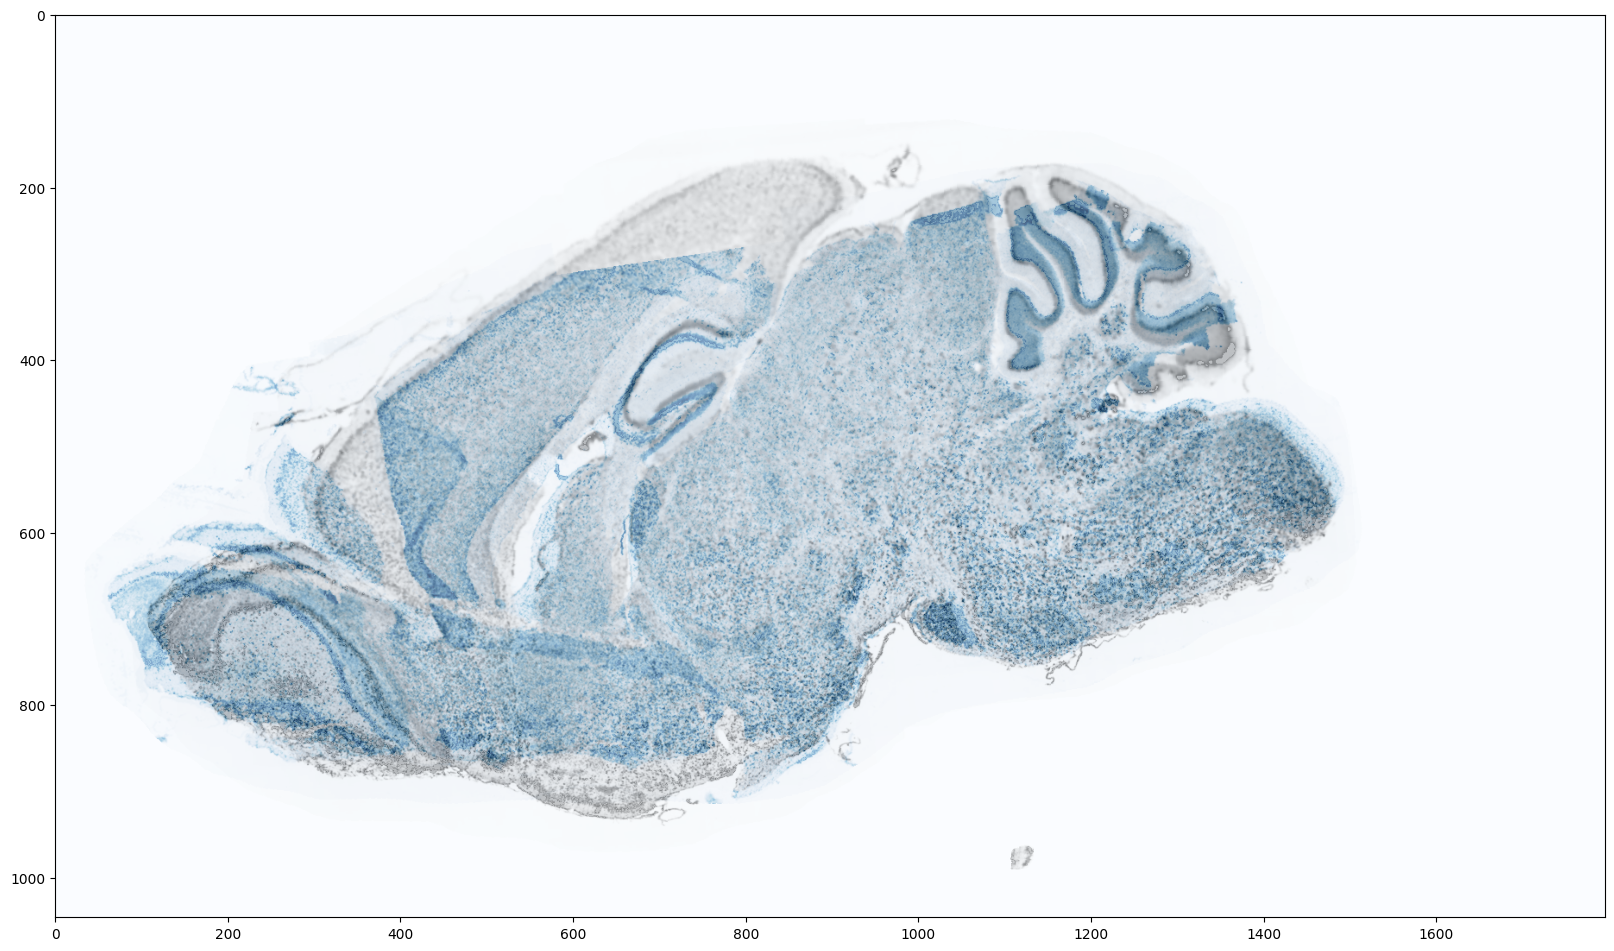

In [26]:
#aligner.evaluate_current_transformation()
aligner.compare_two_image(aligner.fixed, aligner.moving)

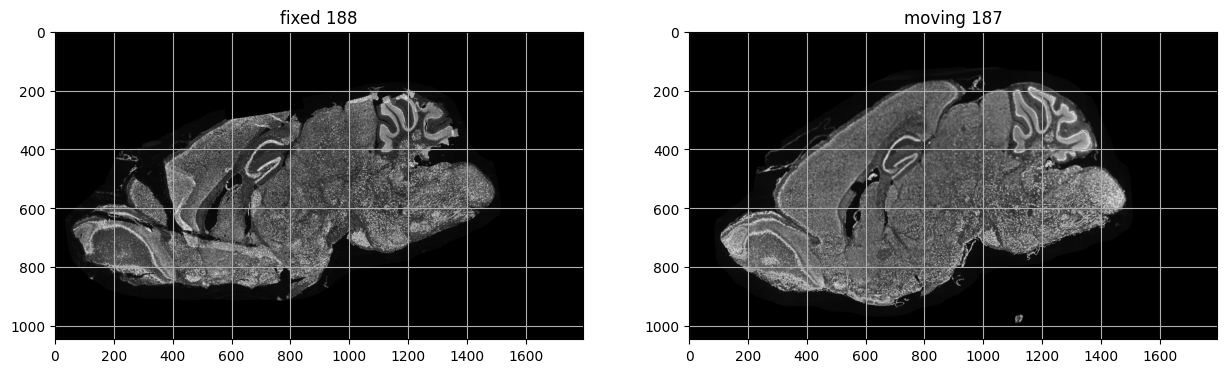

In [27]:
aligner.image_side_by_side(aligner.fixed, aligner.moving)

In [73]:
rotation, xshift, yshift = aligner.load_elastix_transformation(aligner.animal, aligner.fixed_index)
print(f'fixed index = {aligner.fixed_index}')
print(f'rotation of fixed = {rotation}')
print(f'xshift of fixed = {xshift}')
print(f'yshift of fixed = {yshift}')

fixed index = 188
rotation of fixed = 0.0833328
xshift of fixed = 25.6231
yshift of fixed = -2.5728


- preceding image = moving image
- increase xshift of fixed pushes preceding images to the right
- decrease xshift of fixed pushes preceding images to the left
- increase yshift of fixed pushes preceding images down
- decrease yshift of fixed pushes preceding images up
- increase rotation of fixed rotates preceding images clockwise
- decrease rotation of fixed rotates preceding images counterclockwise


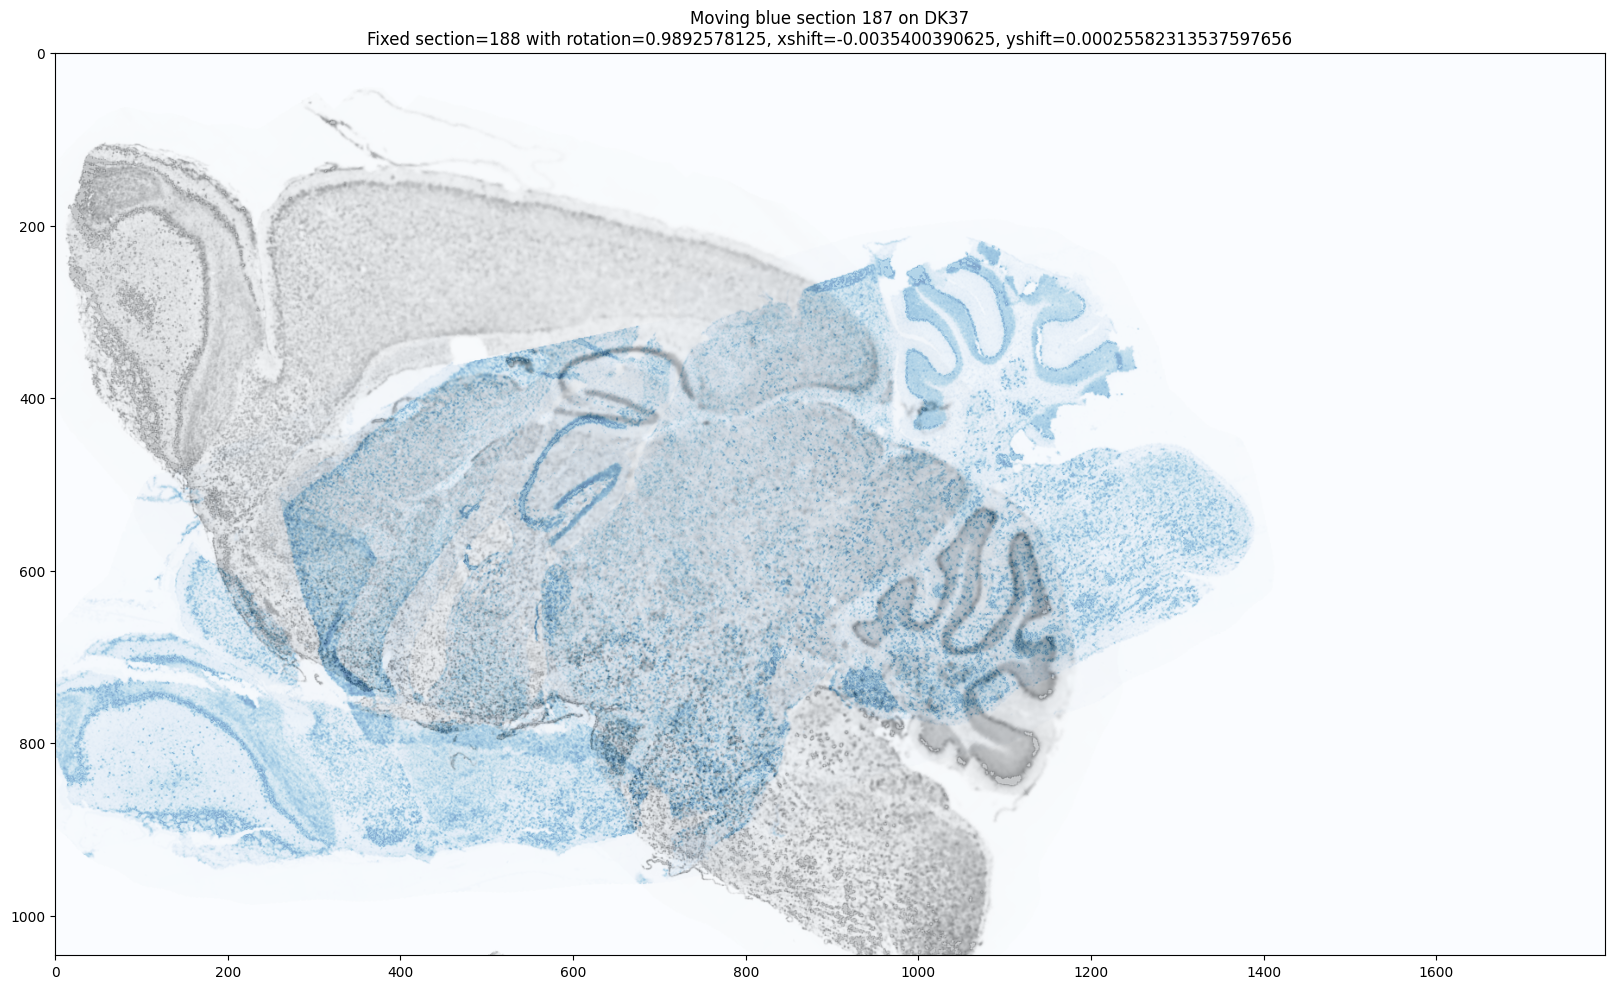

In [72]:
## moving = blue, fixed = grey, previous image
#rotation = 0.3
#xshift = -300
#yshift = -20
T1 = aligner.get_transformation_of_section(aligner.moving_index)
T2 = aligner.get_modified_transformation_of_section(aligner.fixed_index, rotation, xshift, yshift)
aligner.evalulate_transformation(aligner.fixed, aligner.moving, T1, T2)
title = f'Moving blue section {aligner.moving_index} on {prep_id}'
title += f'\nFixed section={aligner.fixed_index} with rotation={rotation}, xshift={xshift}, yshift={yshift}'
plt.title(title);

In [101]:
#r1, r2, r3, r4, r5, r6 = (0.989326, -0.00353943, 0.000255821, 0.974934, 0.0125041, 1.46854)
#T = np.array([0.989326, -0.00353943, 0.000255821, 0.974934, 0.0125041, 1.46854])
src = aligner.moving
rotation = np.pi/4
xshift = 0
yshift = 0
center = np.array([src.shape[1], src.shape[0]]) / 2

R = np.array(
        [
            [np.cos(rotation), -np.sin(rotation)],
            [np.sin(rotation), np.cos(rotation)],
        ]
)
shift = center + (xshift, yshift) - np.dot(R, center)

T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
T

array([[   0.70710678,   -0.70710678,  632.83495706],
       [   0.70710678,    0.70710678, -181.79873607],
       [   0.        ,    0.        ,    1.        ]])

In [96]:
shift

array([ 632.83495706, -481.79873607])

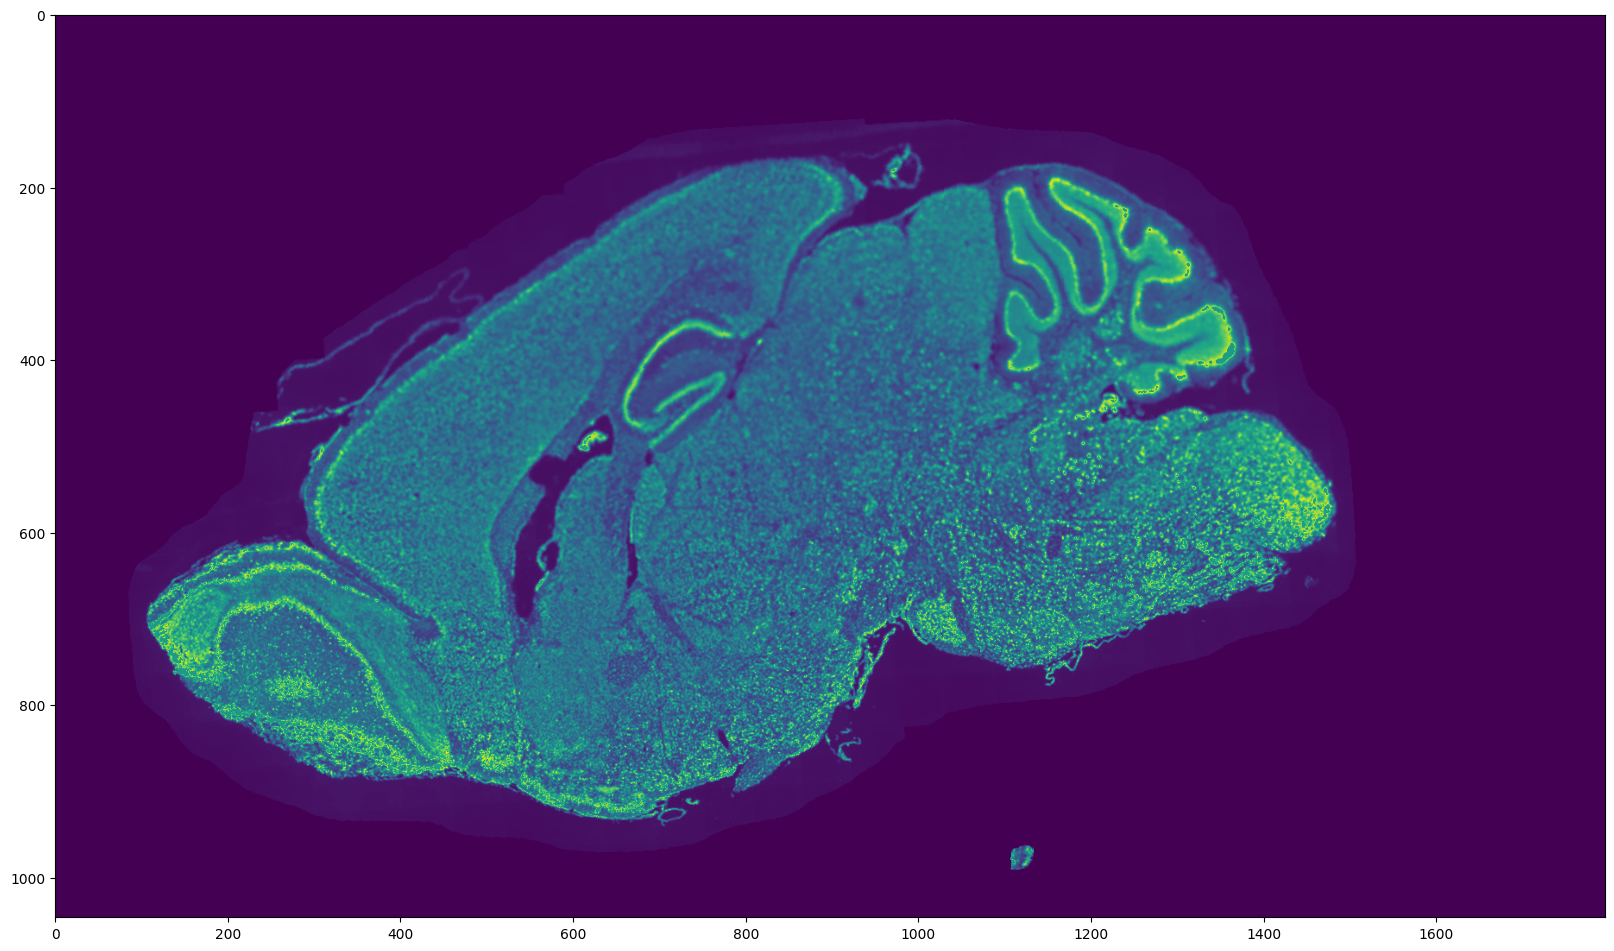

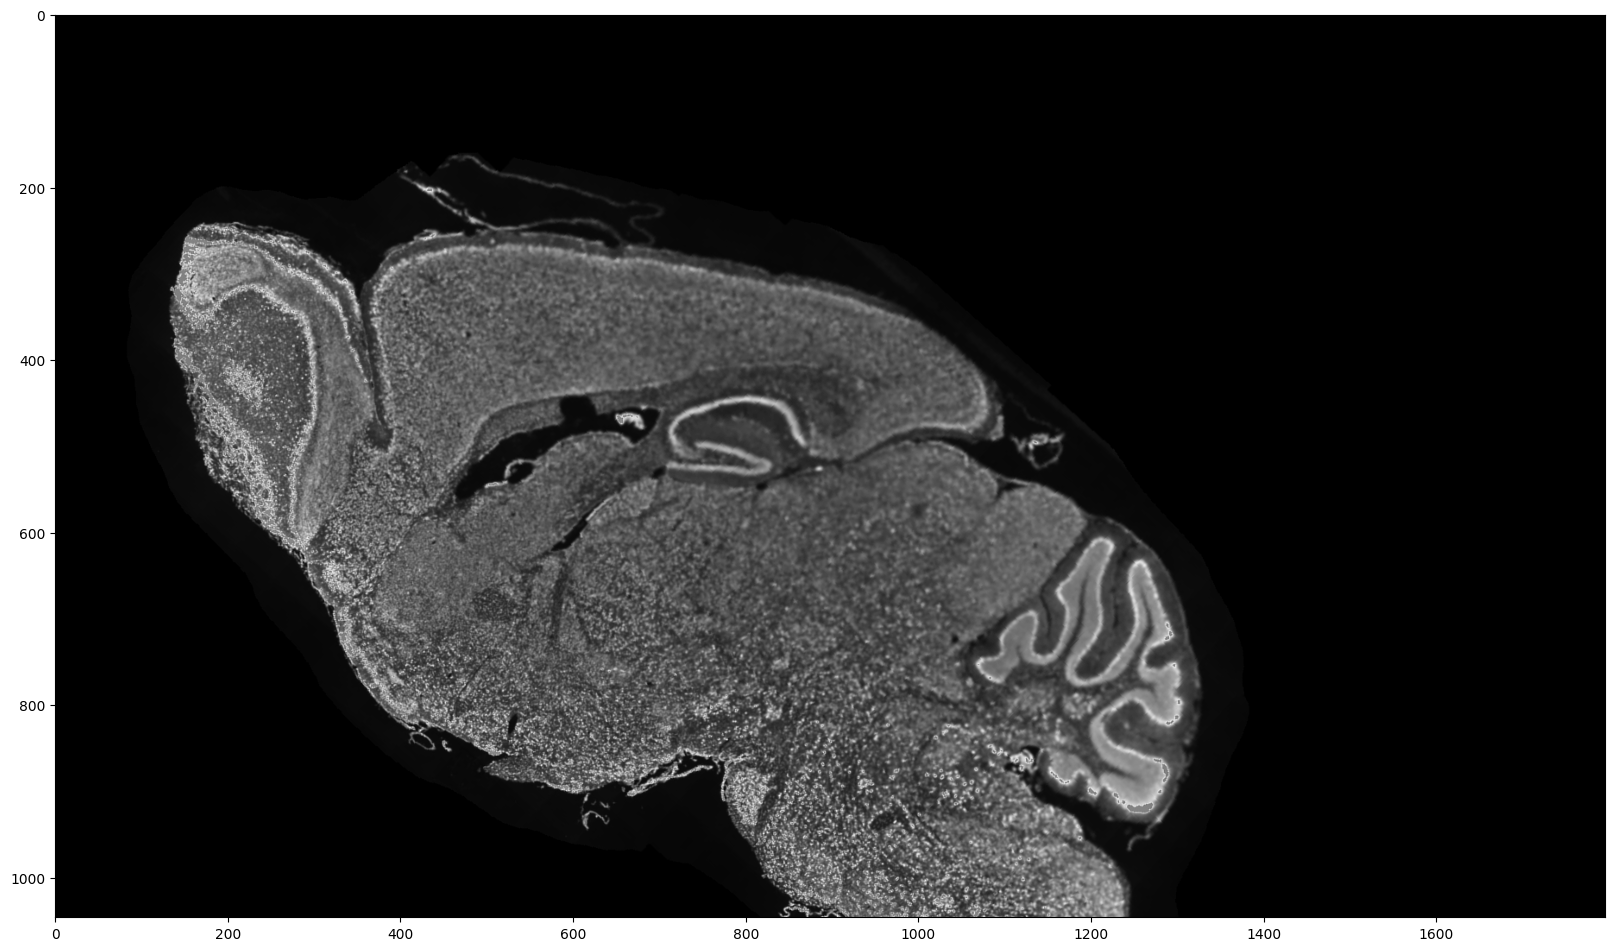

In [102]:
c_in = 0.5 * np.array(src.shape)
dest_shape = (512, 1028)
c_out = 0.5 * np.array(dest_shape)
plt.rcParams["figure.figsize"] = (20,30)
plt.imshow(src)
rot = np.array([[np.cos(r1), -np.sin(r1)], [np.sin(r1), np.cos(r1)]])
invRot = rot.T
invScale = np.diag((1.0, 0.5))
invTransform = np.dot(invScale, invRot)
#dest = scipy.ndimage.affine_transform(
#    src, invTransform, order=2, offset=offset, output_shape=dest_shape, cval=0.0, output=np.float32)
dest = scipy.ndimage.affine_transform(src, T)
plt.figure()
plt.imshow(dest, cmap="gray")